In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import cv2
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import plot_model
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

%matplotlib inline

np.random.seed(39)
tf.random.set_seed(39)

Using TensorFlow backend.


In [2]:
# Adapted from:
# Keras data generators and how to use them
# https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

class DataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, labels, image_path, mask_path,
                 to_fit = True, batch_size = 32, dim = (256, 256),
                 n_channels = 1, n_classes = 10, shuffle = True):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.labels = labels
        self.image_path = image_path
        self.mask_path = mask_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch

        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data

        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch

        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images

        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.expand_dims(self._load_grayscale_image(self.image_path + self.labels[ID]), axis = -1)

        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks

        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            y[i,] = np.expand_dims(self._load_grayscale_image(self.mask_path + self.labels[ID]), axis = -1)

        return y

    def _load_grayscale_image(self, image_path):
        """Load grayscale image

        :param image_path: path to image to load
        :return: loaded image
        """
        img = cv2.imread(image_path, 0)
        img = img / 255.
        return img

In [3]:
def tv_mse_loss(lambda_tv = 0.003):
    def loss(y_true, y_pred):
        y_pred = tf.where(tf.math.is_nan(y_pred), tf.zeros_like(y_pred), y_pred)
        tv = tf.reduce_sum(tf.image.total_variation(y_pred))
        actual_loss = tf.reduce_mean(tf.math.squared_difference(y_pred, y_true)) + lambda_tv * tv
        return actual_loss
    return loss

def psnr_metric(y_true, y_pred):
    y_pred = tf.where(tf.math.is_nan(y_pred), tf.zeros_like(y_pred), y_pred)
    return tf.image.psnr(y_true, y_pred, 1.0)

In [4]:
inp = keras.layers.Input(shape=(256, 256, 1))
x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(inp)
for i in range(6):
    x = keras.layers.Conv2D(64, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(1, 3, padding="same", activation='relu')(x)
x = keras.layers.Lambda(lambda inputs: inputs[0] / inputs[1])([inp, x])
out = keras.layers.Activation('tanh')(x)

model = keras.models.Model(inputs = inp, outputs = out)
model.compile(optimizer='adam', loss="mean_squared_error", metrics=[psnr_metric])

In [5]:
train_idx = [str(i).zfill(5) + ".jpg" for i in range(1, 31501)]
train_gen = DataGenerator(list(range(0, 31500)), train_idx, image_path = '/kaggle/input/simsar/noisy_1c/', mask_path = '/kaggle/input/simsar/clean_1c/')

In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_2[0][0]                   
____________________________________________________________________________________________

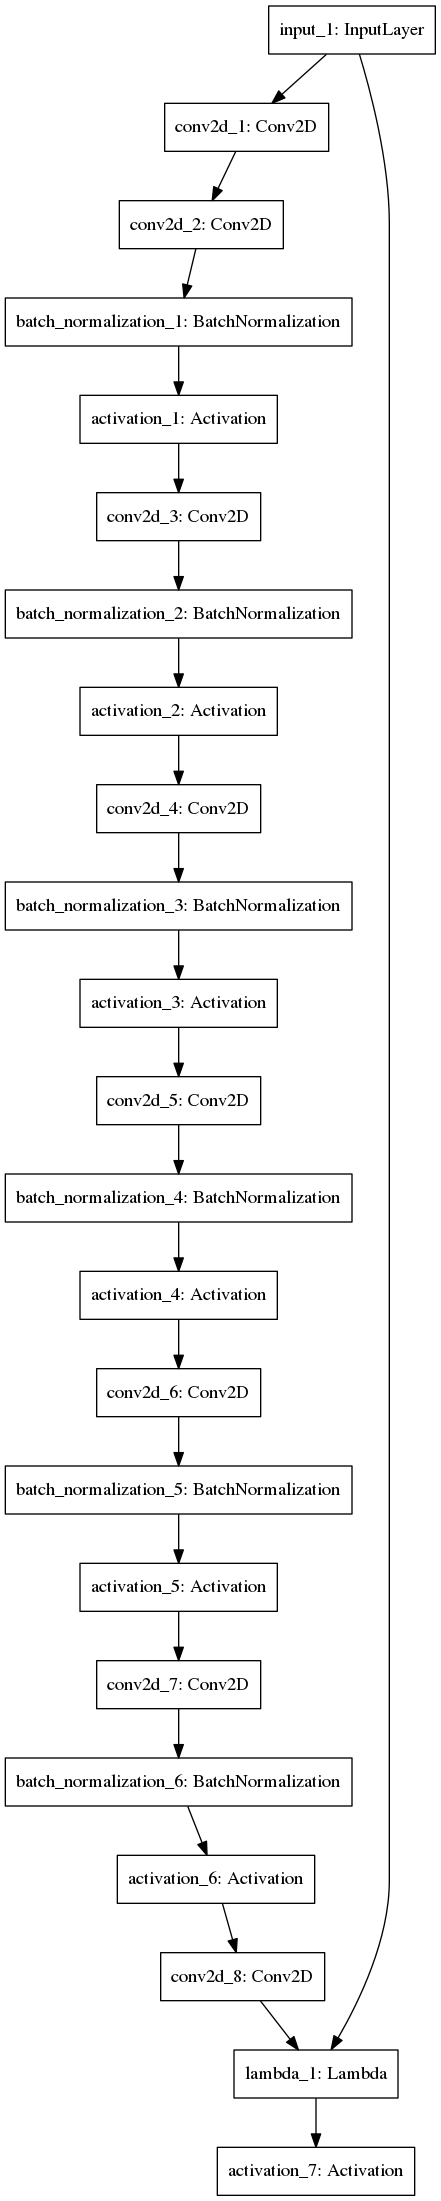

In [7]:
plot_model(model)

In [8]:
hist = model.fit_generator(train_gen, epochs = 20)

Epoch 1/20
984/984 [==============================] - 794s 807ms/step - loss: nan - psnr_metric: 19.4343
Epoch 2/20
984/984 [==============================] - 788s 801ms/step - loss: nan - psnr_metric: 20.3373
Epoch 3/20
984/984 [==============================] - 787s 800ms/step - loss: nan - psnr_metric: 20.7948
Epoch 4/20
984/984 [==============================] - 787s 800ms/step - loss: nan - psnr_metric: 21.2153
Epoch 5/20
984/984 [==============================] - 787s 800ms/step - loss: nan - psnr_metric: 21.1467
Epoch 6/20
984/984 [==============================] - 787s 800ms/step - loss: nan - psnr_metric: 21.4353
Epoch 7/20
984/984 [==============================] - 787s 800ms/step - loss: nan - psnr_metric: 21.7383
Epoch 8/20
984/984 [==============================] - 788s 800ms/step - loss: nan - psnr_metric: 21.7773
Epoch 9/20
984/984 [==============================] - 787s 800ms/step - loss: nan - psnr_metric: 22.0032
Epoch 10/20
984/984 [==============================] - 

In [9]:
print(hist.history['psnr_metric'])
with open("psnr.txt", "w") as f:
    for s in hist.history['psnr_metric']:
        f.write(str(s) +"\n")

[19.434319, 20.337292, 20.794786, 21.215326, 21.146715, 21.435307, 21.738285, 21.777332, 22.003185, 21.749794, 21.973078, 22.01794, 22.087954, 22.306612, 22.375479, 22.447351, 22.47067, 22.536737, 22.603468, 22.647413]


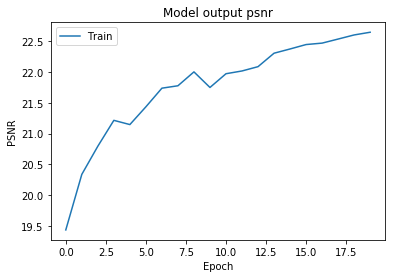

In [10]:
plt.plot(hist.history['psnr_metric'])
plt.title('Model output psnr')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.savefig('/kaggle/working/psnr_curve.svg')

In [11]:
model.save('/kaggle/working/simsar-baseline_v4_07032020_idcnn_20epochs.h5')

In [12]:
x_batch, y_batch = train_gen.__getitem__(1)

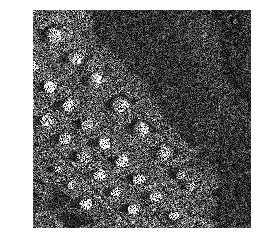

In [13]:
plt.imshow(x_batch[0,:,:,0], cmap = 'gray')
plt.axis('off')
plt.savefig('noisy.png')

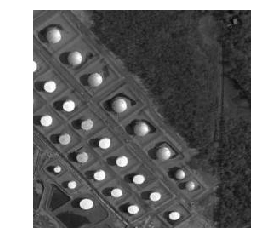

In [14]:
plt.imshow(y_batch[0,:,:,0], cmap = 'gray')
plt.axis('off')
plt.savefig('clean.png')

In [15]:
print("PSNR: ", peak_signal_noise_ratio(y_batch[0,:,:,0], x_batch[0,:,:,0]))
print("SSIM: ", structural_similarity(y_batch[0,:,:,0], x_batch[0,:,:,0]))

PSNR:  13.940761827589522
SSIM:  0.2156053064256666


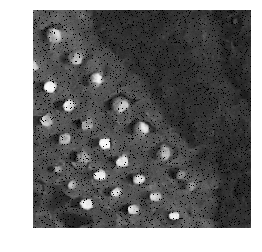

In [16]:
pred = model.predict(x_batch)
pred = np.nan_to_num(pred)
plt.imshow(pred[0,:,:, 0], cmap = 'gray')
plt.axis('off')
plt.savefig('output.png')

In [17]:
print("PSNR: ", peak_signal_noise_ratio(y_batch[0,:,:,0], pred[0,:,:,0]))
print("SSIM: ", structural_similarity(y_batch[0,:,:,0], pred[0,:,:,0]))

PSNR:  20.793992257230514
SSIM:  0.5383675760527461


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  
